# S11 T01: Aprendizaje No Supervisado - Agrupaciòn
___
**Descripción**
Vamos a practicar ya familiarizarnos con algoritmos de clustering.
___
**Objetivos**
- Kmeans
- Clustering jeràrquic

In [1]:
#load libreries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from math import sqrt
import category_encoders as ce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from kneed import KneeLocator
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

Primeros pasos:
- 1. Cargar base de datos (se carga la base de datos previamente procesada)

In [2]:
#import te clean dataset 
data = pd.read_csv('df_clean_dbdelay.csv')

- 2. Overview de la base de datos


In [3]:
data.shape

(1928371, 17)

In [4]:
data.head()

,Unnamed: 0,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,Date
0,0,4,2003,1955,2211,2225,WN,335,128,150,116,-14,8,IAD,TPA,810,2008-01-03
1,1,4,754,735,1002,1000,WN,3231,128,145,113,2,19,IAD,TPA,810,2008-01-03
2,2,4,628,620,804,750,WN,448,96,90,76,14,8,IND,BWI,515,2008-01-03
3,3,4,1829,1755,1959,1925,WN,3920,90,90,77,34,34,IND,BWI,515,2008-01-03
4,4,4,1940,1915,2121,2110,WN,378,101,115,87,11,25,IND,JAX,688,2008-01-03


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1928371 entries, 0 to 1928370
Data columns (total 17 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   Unnamed: 0         int64 
 1   DayOfWeek          int64 
 2   DepTime            int64 
 3   CRSDepTime         int64 
 4   ArrTime            int64 
 5   CRSArrTime         int64 
 6   UniqueCarrier      object
 7   FlightNum          int64 
 8   ActualElapsedTime  int64 
 9   CRSElapsedTime     int64 
 10  AirTime            int64 
 11  ArrDelay           int64 
 12  DepDelay           int64 
 13  Origin             object
 14  Dest               object
 15  Distance           int64 
 16  Date               object
dtypes: int64(13), object(4)
memory usage: 250.1+ MB


In [6]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1928371.0,967883.210651,558868.992129,0.0,483955.5,967654.0,1451881.5,1936757.0
DayOfWeek,1928371.0,3.984999,1.996050,1.0,2.0,4.0,6.0,7.0
DepTime,1928371.0,1518.647818,450.435200,1.0,1203.0,1545.0,1900.0,2400.0
CRSDepTime,1928371.0,1467.717509,424.728051,0.0,1135.0,1510.0,1815.0,2359.0
ArrTime,1928371.0,1610.242251,548.000926,1.0,1316.0,1715.0,2030.0,2400.0
CRSArrTime,1928371.0,1634.196234,464.628444,0.0,1325.0,1705.0,2014.0,2359.0
FlightNum,1928371.0,2184.296091,1944.449506,1.0,611.0,1543.0,3423.0,9741.0
ActualElapsedTime,1928371.0,133.305863,72.060069,14.0,80.0,116.0,165.0,1114.0
CRSElapsedTime,1928371.0,134.197674,71.233388,-21.0,82.0,116.0,165.0,660.0
AirTime,1928371.0,108.277147,68.642610,0.0,58.0,90.0,137.0,1091.0


- 3. Limpieza de datos

In [7]:
round(data[:].isnull().sum() * 100 / data.shape[0], 2)

Unnamed: 0           0.0
DayOfWeek            0.0
DepTime              0.0
CRSDepTime           0.0
ArrTime              0.0
CRSArrTime           0.0
UniqueCarrier        0.0
FlightNum            0.0
ActualElapsedTime    0.0
CRSElapsedTime       0.0
AirTime              0.0
ArrDelay             0.0
DepDelay             0.0
Origin               0.0
Dest                 0.0
Distance             0.0
Date                 0.0
dtype: float64

In [6]:
#remove unimportant columns
data = data.drop(['Unnamed: 0'], axis = 1)

Modificacion del dtype de las variables:

In [7]:
#data type object to categoric variables
data[['UniqueCarrier','Origin','Dest']] = data[['UniqueCarrier','Origin','Dest']].astype('category')

In [8]:
data['Date'] = pd.to_datetime(data['Date'])

In [9]:
#data float to int
data[["ActualElapsedTime","CRSElapsedTime","AirTime",'ArrDelay','DepDelay','CRSDepTime','DepTime','CRSArrTime','ArrTime']] = data[["ActualElapsedTime","CRSElapsedTime","AirTime",'ArrDelay','DepDelay','CRSDepTime','DepTime','CRSArrTime','ArrTime']].astype('int64')

In [10]:
data.head()

,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,Date
0,4,2003,1955,2211,2225,WN,335,128,150,116,-14,8,IAD,TPA,810,2008-01-03
1,4,754,735,1002,1000,WN,3231,128,145,113,2,19,IAD,TPA,810,2008-01-03
2,4,628,620,804,750,WN,448,96,90,76,14,8,IND,BWI,515,2008-01-03
3,4,1829,1755,1959,1925,WN,3920,90,90,77,34,34,IND,BWI,515,2008-01-03
4,4,1940,1915,2121,2110,WN,378,101,115,87,11,25,IND,JAX,688,2008-01-03


## Nivel 1

### - Ejercicio 1
Agrupa los distintos vuelos utilizando el algoritmo de K-means.
<br>
___
**Clustering** es una serie de tecnicas utilizadas para dividir la informacion en grupos (clusters).
> *Clusters are loosely defined as groups of data objects that are more similar to other objects in their cluster than they are to data objects in other clusters*

Ayuda a identificar dos cualidades en los datos: Meaningfulness and Usefulness
>Meaningful clusters expand domain knowledge.

>Useful clusters, on the other hand, serve as an intermediate step in a data pipeline.
___

*https://realpython.com/k-means-clustering-python/*

## Sampling the variables
Al tener casi dos millones de datos, se hace un muestreo aleatorio simple para poder optimizar los tiempos de calculo del notebook.
<br>

El sampling por calculo nos dice que una muestra valida puede ser de 400 datos, pero para abarcar un expectro mayor de datos, se ha decidido usar una muestra de diez mil datos

In [12]:
#Simple Random Sampling
data_sampling = data.sample(10000)
data_sampling.head()

,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,Date
1465907,5,1721,1701,1903,1854,UA,1539,162,173,142,9,20,MCO,ORD,1005,2008-09-19
1783902,4,750,740,1035,1028,OH,6722,105,108,88,7,10,HSV,DCA,613,2008-12-18
1826463,1,2102,1835,2227,1950,WN,3139,85,75,56,157,147,SJC,LAX,308,2008-12-01
664911,2,1942,1935,2029,2018,HA,398,47,43,28,11,7,HNL,KOA,163,2008-04-01
584939,1,1520,1510,1627,1620,WN,288,67,70,57,7,10,STL,OMA,342,2008-04-14


### Feature engineering: Normalization of categorical data
Para trabajar los modelos de machine learning es necesario que pueda interpretar los datos de manera correcta, por lo que se van a normalizar las variables categoricas. En este dataset las variables categoricas de interes son 'UniqueCarrier', 'Dest' y 'Origin', pero debido a que la lista de observaciones diferentes es muy amplia podriamos terminar con un dataset de mas de 600 features, por lo que se va a utilizar *target encoder* para no aumentar el tamaño del dataset y faciliar su procesamiento.

*https://medium.com/analytics-vidhya/target-encoding-vs-one-hot-encoding-with-simple-examples-276a7e7b3e64*


In [14]:
encoder = TargetEncoder()
data_sampling[['Origin','Dest','UniqueCarrier']]=encoder.fit_transform(data_sampling[['Origin','Dest','UniqueCarrier']],data_sampling['ArrDelay'])

data_sampling.head()

C:\Users\Usuario\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,Date
1465907,5,1721,1701,1903,1854,44.326897,1539,162,173,142,9,20,37.035533,58.875686,1005,2008-09-19
1783902,4,750,740,1035,1028,52.629091,6722,105,108,88,7,10,59.529410,36.516484,613,2008-12-18
1826463,1,2102,1835,2227,1950,32.888889,3139,85,75,56,157,147,28.950000,40.464407,308,2008-12-01
664911,2,1942,1935,2029,2018,13.869565,398,47,43,28,11,7,23.000000,19.002841,163,2008-04-01
584939,1,1520,1510,1627,1620,32.888889,288,67,70,57,7,10,37.482353,34.537037,342,2008-04-14


### Standardize the data
Los dataset suelen incluir diferentes tipos de variables y en diferentes unidades, para que un algoritmo de la misma importancia a todos los valores, se realiza una estandarizacion de los datos. 

In [17]:
#copy of dataset
std_sc_data=data_sampling.copy()
std_sc_data = std_sc_data.drop(['Date'], axis=1)


#apply the standarization to features
sc_data = pd.DataFrame(StandardScaler().fit_transform(std_sc_data))
sc_data = pd.DataFrame(std_sc_data, columns= std_sc_data.columns)

### Principal Component Analysis (PCA) 
En problemas practicos de ML requieren de multiples modificaciones a los datos, la reduccion en la dimension de los datos se encuentra entre los metodos importantes. Esta tecnica reduce el numero de variables en el dataset removiendolas o combinandolas. Lo que permite reduce la dificultad para encontrar objetos cercanos to otros en grandes dimensionalidades, evitando sparsity in the feature space. 

In [22]:
# PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(sc_data)
pca.explained_variance_ratio_.sum().round(2)

0.95

Se observa que al dividir en 3 componentes se mantiene una varianza de los datos del 95%, lo cual es aceptable.

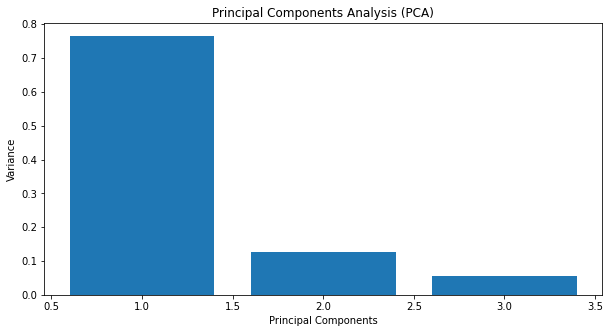

In [32]:
# Plot
prin_comp = range(1, pca.n_components_+1)
plt.figure(figsize=(10,5))
plt.bar(prin_comp, pca.explained_variance_ratio_)
plt.xlabel('Principal Components'); 
plt.ylabel('Variance'); 
plt.title('Principal Components Analysis (PCA)');
plt.show()

### K-means clustering
- Seleccionar aleatoriamente 'k centroids', donde *k* es igual al numero de clusters seleccionados. *centroids* son datapoints que representan el centro del cluster.
- Expectation - maximization: expectation asigna cada data point al centroide mas cercano. Luego maximization computa la media de todos los puntos por cada cluster y establece el nuevo centroide.

>La calidad del cluster se determina con la suma del squared error (SSE) despues de que los centroides convergen.

> la inicializacion aleatoria causa que el algoritmo sea nondeterministic, lo que significa que variara cada que se corra el mismo algoritmo en el mismo dataset.

#### Escoger el numero apropiado de Clusters
1. Elbow method.
evaluacion complementaria que corre k-means varias veces, incrementando k en cada iteracion y guardando el SSE.

In [33]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(principal_components)
    sse.append(kmeans.inertia_)

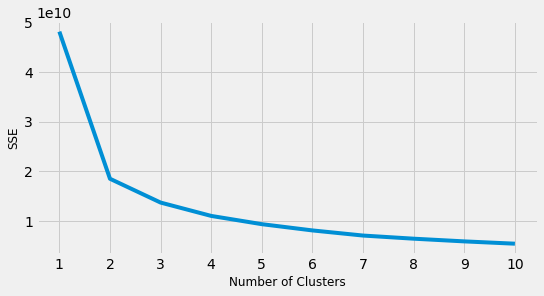

In [57]:
fig, ax = plt.subplots(figsize = (8,4))
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters",fontsize = 12)
plt.ylabel("SSE",fontsize = 12)
plt.rcParams["font.size"] = "10"
plt.show()

Al imprimir SSE como funcion, se observa que SSE disminuye con respecto al incremento de k. Pues cuando mas centroides se agregan, la distancia entre cada punto al centroide mas cercano disminuye.
<br>

Hay un punto donde la curva SSE genera lo que se llama *elbow point*, el valor en x de este punto es considerado un trade-off razonable entre error y numero de clusters. En este caso el elbow se encuentra en ***x=3***.

In [59]:
#python package to identify the elbow
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
print('El numero de cluster se encuentra en el elbow:',kl.elbow)

El numero de cluster se encuentra en el elbow: 3


2. Silhouette coefficient
Es una medida de cohesion y separacion en los cluster, cuantifica que tan bien encaja un data point en el cluster asignado en base a dos factores:
- Que tan cerca se encuentran los data points en el cluster
- que tan lejanos se encuentran los data points de otros cluster.

> los valores se encuentran entre -1 a 1, entre mas grande es el numero indica que los datos estan mas cercanos a sus clusters de lo que estan a otros clusters.

In [55]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(principal_components)
    score = silhouette_score(principal_components, kmeans.labels_)
    silhouette_coefficients.append(score)

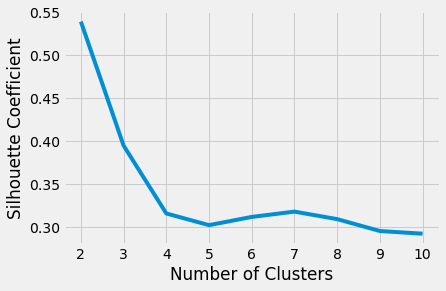

In [56]:
#plot the average silhouette
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Gracias al silhouette coefficient se puede observar que el numero de clusters optimo es 2, a diferencia del elbow que fue calculado como 3. 
___
### K-Means Clustering Pipeline

In [60]:
def pipelines(data, i):
    # Preprocessing pipeline PCA
    preprocessor  = Pipeline([
        ('pca', PCA(n_components = i, random_state=42))
    ])

    # K-means cluistering pipeline
    clusterer = Pipeline([
        ('kmeans', KMeans(n_clusters=kl.elbow, init = 'k-means++', n_init = 50, max_iter= 500, random_state = 42))
    ])

    # end-to-end k-means clustering pipeline
    pipe = Pipeline([
        ('preprocessing', preprocessing),
        ('clusterer', clusterer)
    ])

    # performs all the pipeline steps on the data
    return pipe.fit(data)

In [76]:
data_pipe = pipelines(sc_data,3)
data_pipe

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('pca',
                                  PCA(n_components=3, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=3, n_init=50,
                                         random_state=42))]))])

In [84]:
# DataFrame
df_pipe = pd.DataFrame(data_pipe['preprocessing'].transform(sc_data), columns = ['PCA1', 'PCA2','PCA3'])

# Predicted cluster
df_pipe['predicted_cluster'] = data_pipe['clusterer']['kmeans'].labels_

df_pipe.head()

,PCA1,PCA2,PCA3,predicted_cluster
0,-724.623320,-446.024385,203.799507,1
1,4516.156643,1228.273536,306.213996,2
2,935.455472,-989.499709,-302.390381,0
3,-1770.233362,-839.693527,-769.130072,1
4,-1878.598680,-8.271681,-641.443714,1


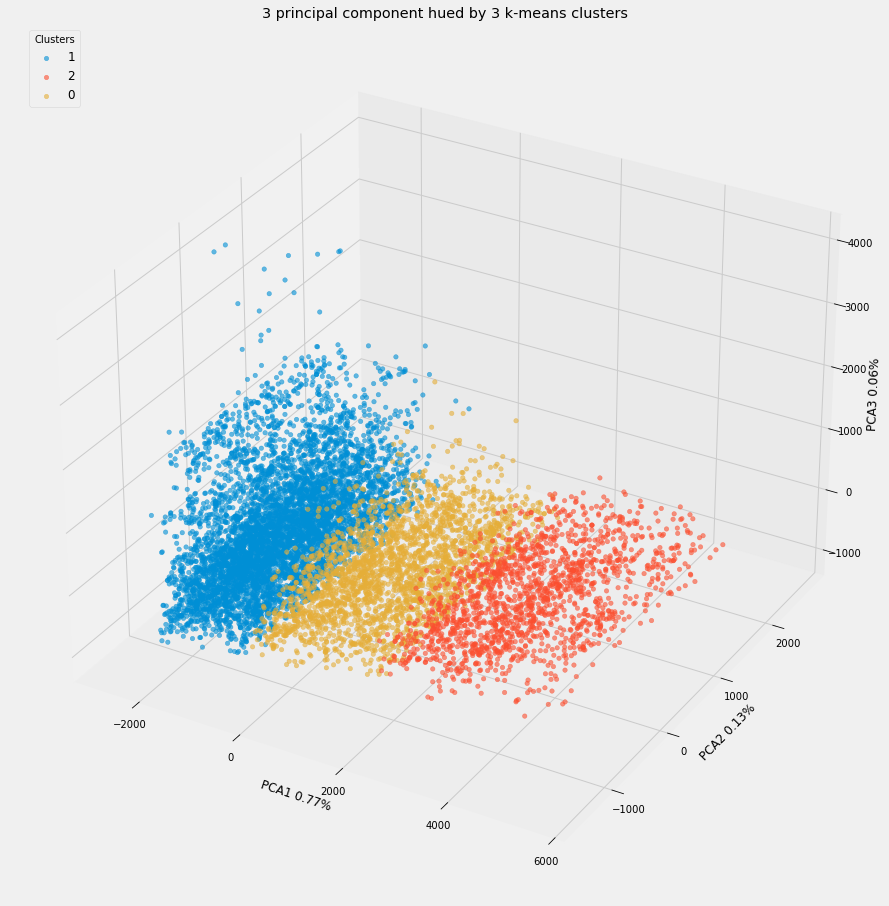

In [92]:
#plot 3 dimensional
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

for s in df_pipe['predicted_cluster'].unique():
    ax.scatter(df_pipe.PCA1[df_pipe['predicted_cluster']==s], 
                   df_pipe.PCA2[df_pipe['predicted_cluster']==s], 
                   df_pipe.PCA3[df_pipe['predicted_cluster']==s],
                   label=s, alpha=0.6)

ax.set(xlabel='PCA1 '+str(round(pca.explained_variance_ratio_[0], 2))+"%",
          ylabel='PCA2 '+str(round(pca.explained_variance_ratio_[1], 2))+"%",
          zlabel='PCA3 '+str(round(pca.explained_variance_ratio_[2], 2))+"%",
          title= "{} principal component hued by {} k-means clusters".format(pca.n_components,3))
plt.legend(title="Clusters", fontsize=12,bbox_to_anchor=(0.09, 1))
plt.rcParams["font.size"] = "8"
plt.show()

La visualizacion de los clusters muestra que tener 3 clusters genera un buen performance del logaritmo, pues los clusters solo se superponen ligeramente.

In [93]:
#add PCA to dataframe
data_kmeans = pd.concat([sc_data.reset_index(drop=True), df_pipe], axis =1)
data_kmeans.head()

,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,PCA1,PCA2,PCA3,predicted_cluster
0,5,1721,1701,1903,1854,44.326897,1539,162,173,142,9,20,37.035533,58.875686,1005,-724.623320,-446.024385,203.799507,1
1,4,750,740,1035,1028,52.629091,6722,105,108,88,7,10,59.529410,36.516484,613,4516.156643,1228.273536,306.213996,2
2,1,2102,1835,2227,1950,32.888889,3139,85,75,56,157,147,28.950000,40.464407,308,935.455472,-989.499709,-302.390381,0
3,2,1942,1935,2029,2018,13.869565,398,47,43,28,11,7,23.000000,19.002841,163,-1770.233362,-839.693527,-769.130072,1
4,1,1520,1510,1627,1620,32.888889,288,67,70,57,7,10,37.482353,34.537037,342,-1878.598680,-8.271681,-641.443714,1


## Nivel 2

### - Ejercicio 2
Agrupa los distintos vuelos utilizando el algoritmo de clustering jerárquico.
<br>

### Hierarchical clustering algorithms 
Agrupa objetos similares en grupos llamados clusters. Existen dos tipos: agglomerative (empieza con muchos clusters pequeños y los combina para crear cluster mas grandes) y divisive (empieza con clusters simples y los divide en clusters menores).

- No asume un numero particular de clusters
- Una vez combinados dos clusters, no puede deshacerse
- Lento en grandes datasets

> **Proceso**
1. convierte cada data point en un cluster
2. toma los dos cluster mas cercanos y los combina en un cluster
3. repite el paso 2 hasta que quede un solo cluster



*https://towardsdatascience.com/machine-learning-algorithms-part-12-hierarchical-agglomerative-clustering-example-in-python-1e18e0075019*

Reutilizando el dataset escalado, normalizado y con PCA generado. Creamos un dendograma para ver el numero optimo de clusters:

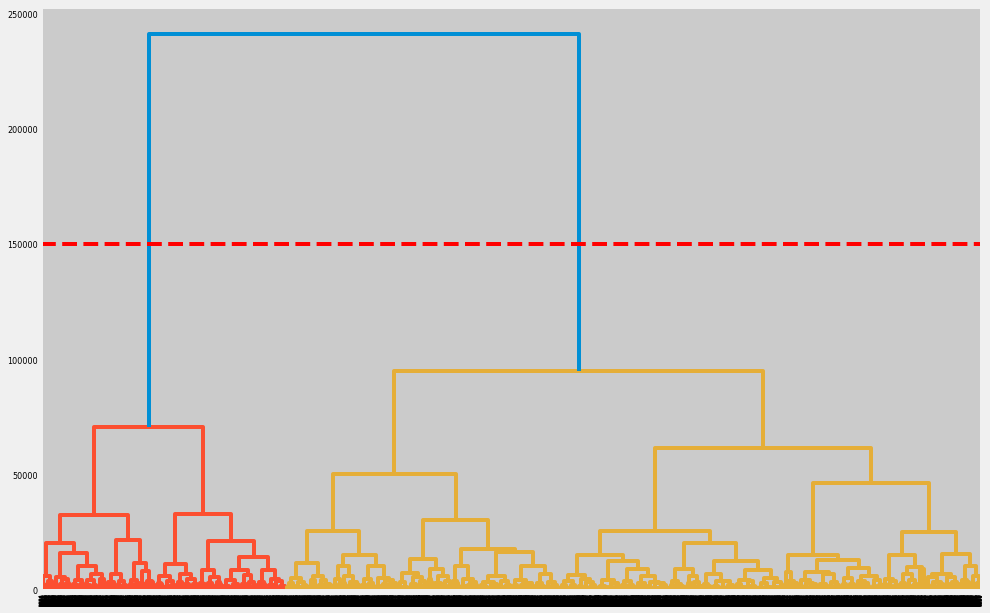

In [105]:
plt.figure(figsize = (15,10))
dendrogram = sch.dendrogram(sch.linkage(df_pipe[['PCA1', 'PCA2','PCA3']], method='ward'))
plt.axhline(y = 150000 , color = 'r', linestyle = '--'); 
plt.rcParams["font.size"] = "8"
plt.show()

Se puede ver que entre mayor sea la distancia entre las lineas verticales del dendograma, mayor es la distancia entre clusters. Por lo que ahora se establece una linea horizontal que divida la linea vertical mas alta y el numero de clusters sera el numero de lineas verticales que son interceptadas por la linea de umbral generada, en este caso de **2**.

___
Para instanciar el logaritmo para el clustering utilizamos los siguientes parametros:
- Euclidean distance: Es la distancia mas corta entre dos puntos
- Ward linkage: la distancia entre clusters es la suma del cuadrado de la diferencia entre los clusters.

In [110]:
#instance of agglomerative clustering
model_cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
model_cluster.fit(df_pipe)
df_pipe['Agglomerative_Hierarchical'] = model_cluster.labels_

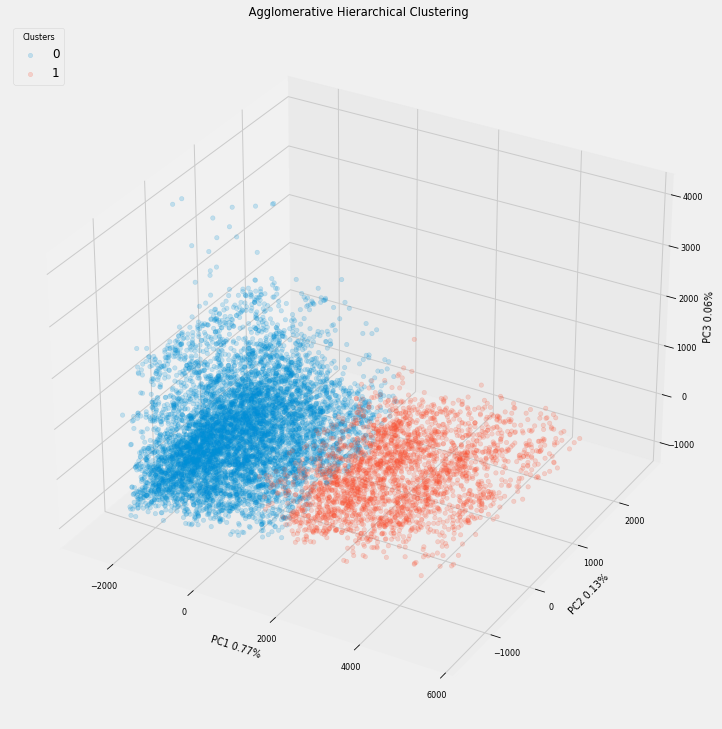

In [112]:
#plot the clusters
fig = plt.figure(figsize = (15,12))
ax = fig.add_subplot(111, projection = '3d') 

for x in list(range(model_cluster.n_clusters)):
    ax.scatter(df_pipe.PCA1[df_pipe.Agglomerative_Hireachical == x],
    df_pipe.PCA2[df_pipe.Agglomerative_Hireachical == x],
    df_pipe.PCA3[df_pipe.Agglomerative_Hireachical == x], label = x, alpha = 0.2)


ax.set(xlabel='PC1 '+str(round(data_pipe['preprocessing']['pca'].explained_variance_ratio_[0], 2))+"%",
          ylabel='PC2 '+str(round(data_pipe['preprocessing']['pca'].explained_variance_ratio_[1], 2))+"%",
          zlabel='PC3 '+str(round(data_pipe['preprocessing']['pca'].explained_variance_ratio_[2], 2))+"%",
          title= " Agglomerative Hierarchical Clustering")
plt.legend(title="Clusters", fontsize=12,bbox_to_anchor=(0.09, 1))
plt.show()


## Nivel 3


### - Ejercicio 3
Calcula el rendimiento del clustering mediante un parámetro como puede ser silueta.

In [97]:
#calculate silhouette
k_silhouette = silhouette_score(data_kmeans[['PCA1', 'PCA2', 'PCA3']], data_kmeans['predicted_cluster']).round(3)
print('El score de k-means es:', k_silhouette)

El score de k-means es: 0.394


In [114]:
# Hirearchical Clustering Silhouette
hc_silhouette = silhouette_score(data_kmeans[['PCA1', 'PCA2', 'PCA3']], df_pipe['Agglomerative_Hierarchical']).round(3)
print('El score de Hirearchical Clustering es:', hc_silhouette)

El score de Hirearchical Clustering es: 0.54


Se puede observar que el algoritmo que se desempeña mejor de acuerdo al parametro silhouette es el Hierarchical clustering.